In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

In [2]:
DATA_PATH = os.path.join("..", "..", "..", "data")  # document-wide constants are uppercase by convention

# 2
## a: Plots

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "sp500.csv"), index_col="Date")
df["log_price"] = np.log(df["Adj Close"])
df["log_return"] = df["log_price"] - df["log_price"].shift(1)
df.dropna(inplace=True)
T = len(df)  # sample size

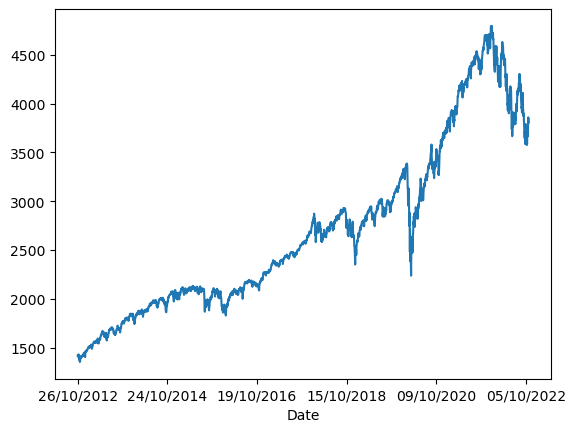

In [4]:
df["Adj Close"].plot()
plt.savefig("sp500.pdf")


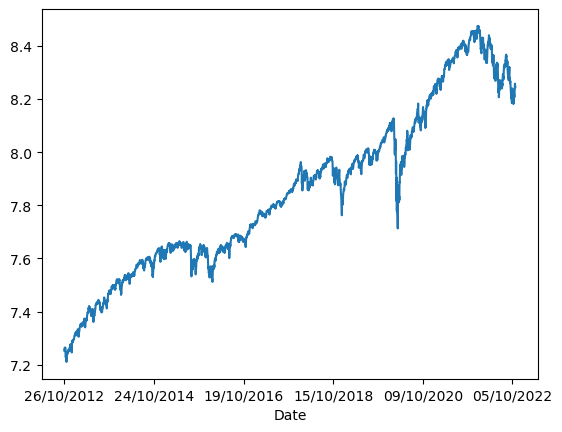

In [5]:
df["log_price"].plot()
plt.savefig("sp500_log_price.pdf")

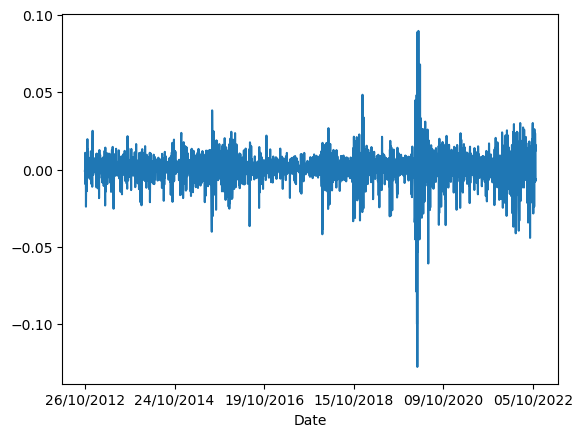

In [6]:
df["log_return"].plot()
plt.savefig("sp500_return.pdf")

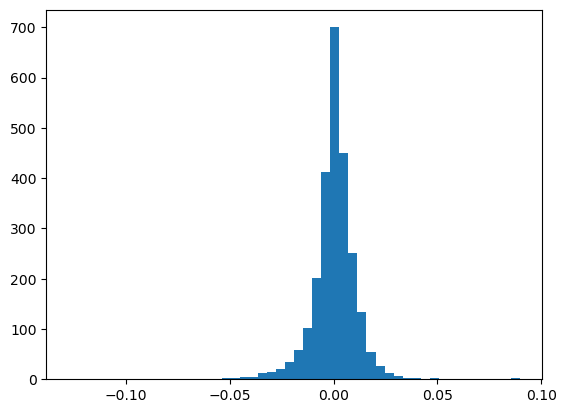

In [7]:
plt.hist(df["log_return"], bins=50)
plt.savefig("sp500_hist.pdf")

It is immediately evident that the plot for the returns is very different from that of the (log) prices. This is because the (log) prices are integrated, while returns are stationary. The histogram clearly shows that the returns do not follow a normal distribution; they have heavy tails, and are skewed. We can confirm this with the Jarque-Bera test.
# b: Jarque-Bera test
First, the manual calculation:


In [8]:
sk = sm.stats.stattools.robust_skewness(df["log_return"])[0]
print(sk)
kt = sm.stats.stattools.robust_kurtosis(df["log_return"], excess=False)[0]
print(kt)
T/6 * sk**2 + T/24 * (kt - 3)**2 

-0.910626884926317
20.189806513026376


31337.32258953989

For a normal distribution, one would expect the skewness and kurtosis to be close to 0 and 3, respectively. This shows that the returns are left-skewed and have heavy tails, a very common finding. The critical value for the JB test is

In [9]:
scipy.stats.chi2.ppf(.95, 2)  # ppf = percent point function = critical values

5.991464547107979

The observed value is much larger than the critical value, so the test rejects the null of normality. Alternatively, we can compute the $p$-value as

In [10]:
scipy.stats.chi2.sf(31337.32, 5)  # sf = survivor function = P(X>x)

0.0

The $p$-value is less than 5%, so again, the test rejects the null that the returns are drawn from a normal distribution. Alternatively, we can make `statsmodels` do the heavy lifting for us. In an exam, I´d expect you to do the calculation yourself though, based on the formula and a table of the $\chi^2$ distribution and given the values of the skewness and kurtosis.

In [11]:
sm.stats.stattools.jarque_bera(df["log_return"])

(31337.322589539886, 0.0, -0.9106268849263176, 20.189806513026376)

## c: Correlogram of the returns
The ACF plot is generated as follows:

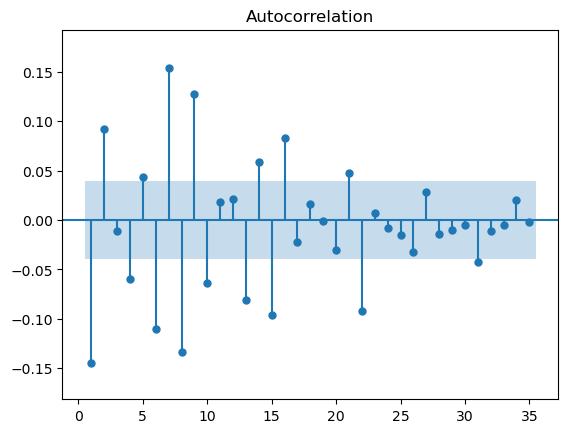

In [12]:
g = sm.graphics.tsa.plot_acf(df["log_return"], bartlett_confint=False, zero=False, auto_ylims=True)
g.savefig("sp500_acf.pdf")

Note that I'm exluding the zero-th order lag, because that is by definition always one. Alternatively, we can obtain the numerical values via

In [13]:
tsa.acf(df["log_return"])[1:11]

array([-0.14522385,  0.09210272, -0.01165013, -0.06017254,  0.04383931,
       -0.1101084 ,  0.1541041 , -0.13354521,  0.12711549, -0.06381351])

again dropping the zero-th order term, and compare with the critical value

In [14]:
1.96 / np.sqrt(T)

0.03906739589898677

The correlogram doesn't show any indication of non-stationarity, so the returns are likely stationary. They don't appear to have been generated by a pure white noise process though, because quite a few autocorrelations are significant at the 5\% level; their absolute values exceed the critical value.

For completeness, we can also plot the PACF:

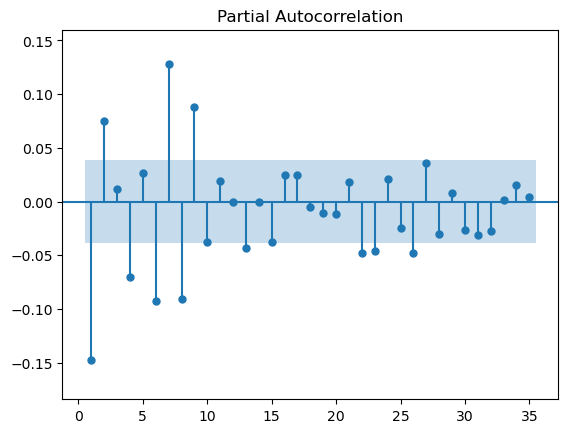

In [15]:
g = sm.graphics.tsa.plot_pacf(df["log_return"], zero=False, auto_ylims=True, method="ols-inefficient");
g.savefig("sp500_pacf.pdf")


## d: Ljung-Box test
The test statistic for testing $H_0: \tau_1=\cdots=\tau_{10}=0$, vs. the alternative that at least one of them is non-zero, is
$$
Q(10)=T(T+2)\sum_{s =1}^{10}\frac{\hat{\tau}_{s }^{2}}{T-s }.
$$
Plugging in $T$ and the autocorrelations from above, this results in an observed test statistic of 275.68.
Comparing this with the critical value

In [16]:
scipy.stats.chi2.ppf(.95, 10)

18.307038053275146

we reject the null and conclude that at least one of the first 10 autocorrelations is different from zero.

Alternatively, we can again let `statsmodels` do the heavy lifting for us:

In [17]:
sm.stats.diagnostic.acorr_ljungbox(df["log_return"])

,lb_stat,lb_pvalue
1,53.146739,3.095389e-13
2,74.532185,6.539456e-17
3,74.874486,3.854848e-16
4,84.009633,2.460691e-17
5,88.860498,1.165864e-17
6,119.473478,2.102105e-23
7,179.461709,2.531020e-35
8,224.529615,4.248635e-44
9,265.378553,5.617980e-52
10,275.677251,2.125260e-53


We're interested in the last row. The final colum gives the $p$-value, which is essentially zero. Thus, we again reject the null.

## e: ACF and PACF of log prices
The plots are generated as follows:

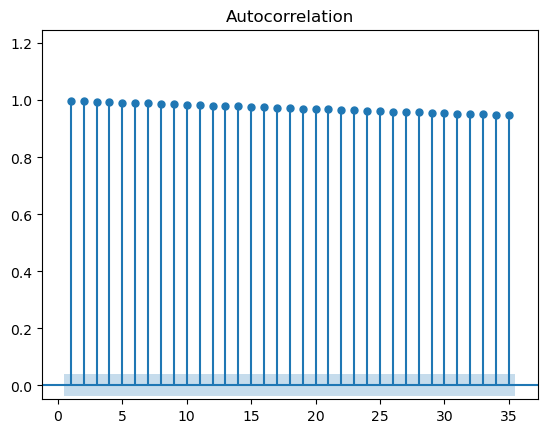

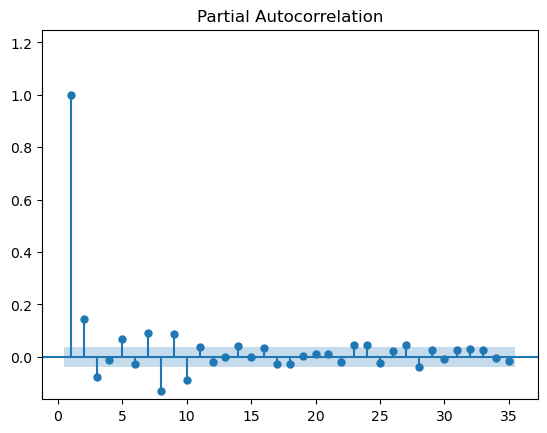

In [18]:
g = sm.graphics.tsa.plot_acf(df["log_price"], bartlett_confint=False, zero=False, auto_ylims=True);
g.savefig("sp500_acf_levels.pdf")
g = sm.graphics.tsa.plot_pacf(df["log_price"], zero=False, auto_ylims=True, method="ols-inefficient");
g.savefig("sp500_pacf_levels.pdf")

The autocorrelations (upper graph) are very high, and appear to decay linearly, not exponentially. This is a clear sign the process that generated the data is integrated. It is not a pure random walk though; for a random walk, we would expect the sample PACF in the bottom graph to become insignificant after the first lag; here, some partial autocorrelations are significant. This, of course, corresponds to the fact that the returns are not pure white noise, as we determined earlier.